Capsule network implementation based on the Cifar10 CNN-Capsule implementation from the keras documentation as well as other online references. (https://keras.io/examples/cifar10_cnn_capsule/, https://theailearner.com/2019/01/21/implementing-capsule-network-in-keras/)

Important: Remeber to run with Python 3.6.1

In [1]:
import keras
import tensorflow as tf
import numpy as np
from keras import backend as K
from keras.datasets import mnist
from keras.layers import Conv2D, Reshape, Layer, Input, Lambda, Flatten, Dense
from keras.models import Model
from keras import utils, initializers, callbacks
from matplotlib import pyplot as plt

Using TensorFlow backend.
F:\Programme\Anaconda\envs\CapsNet\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
F:\Programme\Anaconda\envs\CapsNet\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
F:\Programme\Anaconda\envs\CapsNet\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
F:\Programme\Anaconda\envs\CapsNet\lib\site-packag

In [2]:
# tensorflow-gpu settings
gpu_options = tf.GPUOptions(allow_growth=True)
session = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=gpu_options))

K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0',
 '/job:localhost/replica:0/task:0/device:GPU:1']

In [2]:
# load mnist data set
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.reshape(-1, 28, 28, 1).astype('float32') / 255.
x_test = x_test.reshape(-1, 28, 28, 1).astype('float32') / 255.
y_train = utils.to_categorical(y_train.astype('float32'))
y_test = utils.to_categorical(y_test.astype('float32'))

In [3]:
# (non-linear) squash method from the paper
# added epsilon to prevent division by zero
def squash(vector, axis=-1):
    squared_norm = K.sum(K.square(vector), axis, keepdims = True)
    scale = squared_norm / (1 + squared_norm) / K.sqrt(squared_norm + K.epsilon())
    return scale * vector

In [4]:
# margin-loss as defined in the paper
def margin_loss(y_true, y_pred):
    L = y_true * K.square(K.maximum(0., 0.9 - y_pred)) + 0.5 * (1 - y_true) * K.square(K.maximum(0., y_pred - 0.9))
    return K.mean(K.sum(L, 1))

In [5]:
# custom loss function for training
def sum_squared_error(y_true, y_pred):
    if not K.is_tensor(y_pred):
        y_pred = K.constant(y_pred)
    y_true = K.cast(y_true, y_pred.dtype)
    return K.square(y_pred - y_true)

In [6]:
# custom keras layer
# takes input of size [1152, 8]
# produces output of shape [10, 16]

class DigitCapsuleLayer(Layer):
    def __init__(self, **kwargs):
        super(DigitCapsuleLayer, self).__init__(**kwargs)
        self.kernel_initializer = initializers.get('glorot_uniform')
    
    def build(self, input_shape): 
        # initialize weight matrix for each capsule in lower layer
        self.W = self.add_weight(shape = [10, 6*6*32, 16, 8], initializer = self.kernel_initializer, name = 'weights')
        self.built = True
    
    def call(self, inputs):
        inputs_expand = K.expand_dims(inputs, 1)
        inputs_tiled = K.tile(inputs_expand, [1, 10, 1, 1])
        # matrix multiplication b/w previous layer output and weight matrix
        input_hats = K.map_fn(lambda x: K.batch_dot(x, self.W, [2, 3]), elems=inputs_tiled)
        b = tf.zeros(shape = [K.shape(input_hats)[0], 10, 6*6*32])
        
        # 3 routings as in the paper
        for i in range(3-1):
            c = tf.nn.softmax(b, dim=1)
            s = K.batch_dot(c, input_hats, [2, 2])
            v = squash(s)
            b += K.batch_dot(v, input_hats, [2,3])
            
        return v
    
    def compute_output_shape(self, input_shape):
        return tuple([None, 10, 16])

def output_layer(inputs):
    return K.sqrt(K.sum(K.square(inputs), -1) + K.epsilon())

Als nächstes muss das Model gebaut werden

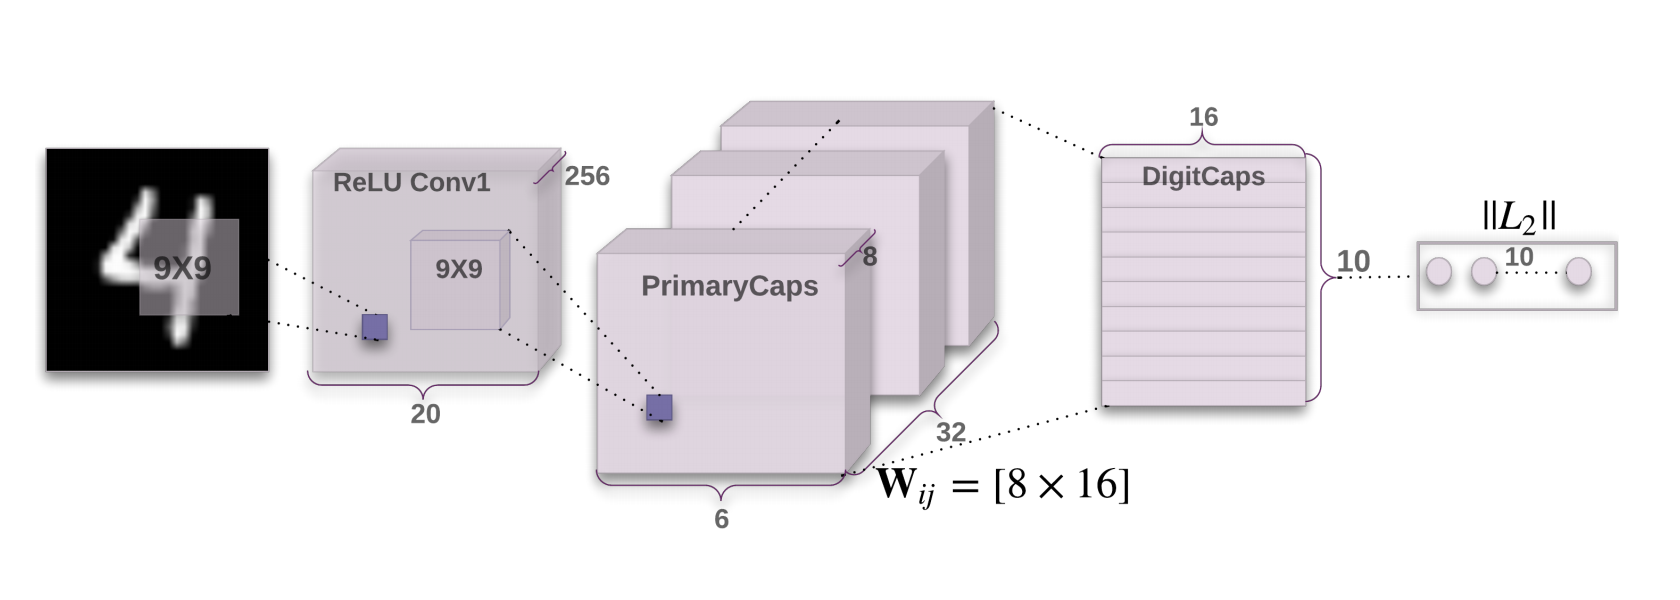

In [7]:
# Build model

# convulution layer 1
input_shape = Input(shape=(28,28,1))  # size of input image is 28*28

conv1 = Conv2D(256, (9,9), activation = 'relu', padding = 'valid')(input_shape)

# primary capsule layer 2
conv2 = Conv2D(256, (9,9), strides = 2, padding = 'valid')(conv1)
reshaped = Reshape((6*6*32,8))(conv2) # 6*6*32 = 1152
squashed_output = Lambda(squash)(reshaped)

# digit capsule layer 3
digit_caps = DigitCapsuleLayer()(squashed_output)
outputs = Lambda(output_layer, name='capsnet')(digit_caps) #shape: [?, 10]

Instructions for updating:
dim is deprecated, use axis instead


In [8]:
# während des Training werden alle Vektoren, die nicht dem korrekten Label entsprechen maskiert, d.h. auf 0 gesetzt
def mask(outputs):
    if type(outputs) != list:  # mask at test time
        norm_outputs = K.sqrt(K.sum(K.square(outputs), -1) + K.epsilon())
        y  = K.one_hot(indices=K.argmax(norm_outputs, 1), num_classes = 10)
        y = Reshape((10,1))(y)
        return Flatten()(y*outputs)
    
    else:    # mask at train time
        y = Reshape((10,1))(outputs[1])
        masked_output = y*outputs[0]
        return Flatten()(masked_output)

# maskiere die Eingabe
inputs = Input(shape = (10,))
masked = Lambda(mask)([digit_caps, inputs]) # The true label is used to mask the output of capsule layer. For training
masked_for_test = Lambda(mask)(digit_caps) # Mask using the capsule with maximal length. For prediction

Im Anschluss muss der Decoder gebaut werden

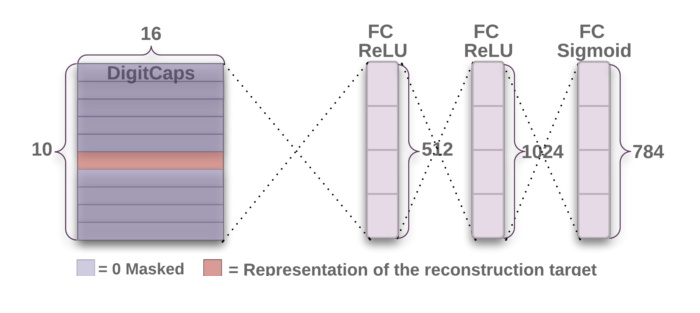

In [9]:
# Build the decoder

decoded_inputs = Input(shape = (16*10,))
dense1 = Dense(512, activation = 'relu')(decoded_inputs)
dense2 = Dense(1024, activation = 'relu')(dense1)
decoded_outputs = Dense(784, activation = 'sigmoid')(dense2)
decoded_outputs = Reshape((28,28,1))(decoded_outputs)

In [10]:
# Erzeuge die Modelle für Training und Evaluation
decoder = Model(decoded_inputs, decoded_outputs, name='decoder')
model_train = Model([input_shape, inputs], [outputs, decoder(masked)])
model_eval = Model(input_shape, [outputs, decoder(masked_for_test)])

In [11]:
# Callbacks zum Speichern der Gewichte (Checkpoints) und zum Erzeugen von TensorBoard Informationen
batch_size = 100
save_dir = './result'

checkpoint = callbacks.ModelCheckpoint(
    save_dir + '/weights-{epoch:02d}.h5', 
    monitor = 'val_capsnet_acc', 
    save_best_only = True, 
    save_weights_only = True, 
    verbose = 1)

tb = callbacks.TensorBoard(
    log_dir = save_dir + '/tensorboard-logs', 
    batch_size = batch_size, 
    histogram_freq = 1)

In [12]:
# Training der Modelle
epochs = 50
weights = './result/trained_model.h5'
training = False
evaluation = True

model_train.compile(
    optimizer=keras.optimizers.Adam(),
    loss=[margin_loss, sum_squared_error],
    loss_weights = [1. ,0.0005],
    metrics = {'capsnet': 'accuracy'})

model_train.summary()

if weights is not None:
    # initialisiere das Modell mit vorhandenen Gewichten
    model_train.load_weights(weights)
    
if training:
    model_train.fit(
        [x_train, y_train],
        [y_train,x_train], 
        batch_size = batch_size, 
        epochs = epochs, 
        validation_data = ([x_test, y_test], [y_test, x_test]),
        callbacks = [checkpoint, tb])
    
    model_train.save_weights(save_dir + '/trained_model.h5')

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 20, 20, 256)  20992       input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 6, 6, 256)    5308672     conv2d_1[0][0]                   
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 1152, 8)      0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
lambda_1 (

In [13]:
# Evaluierung der Modelle
if evaluation:
    label_predicted, image_predicted = model_eval.predict(x_test)
    print('Test acc:', np.sum(np.argmax(label_predicted, 1) == np.argmax(y_test, 1))/y_test.shape[0])

Test acc: 0.9881


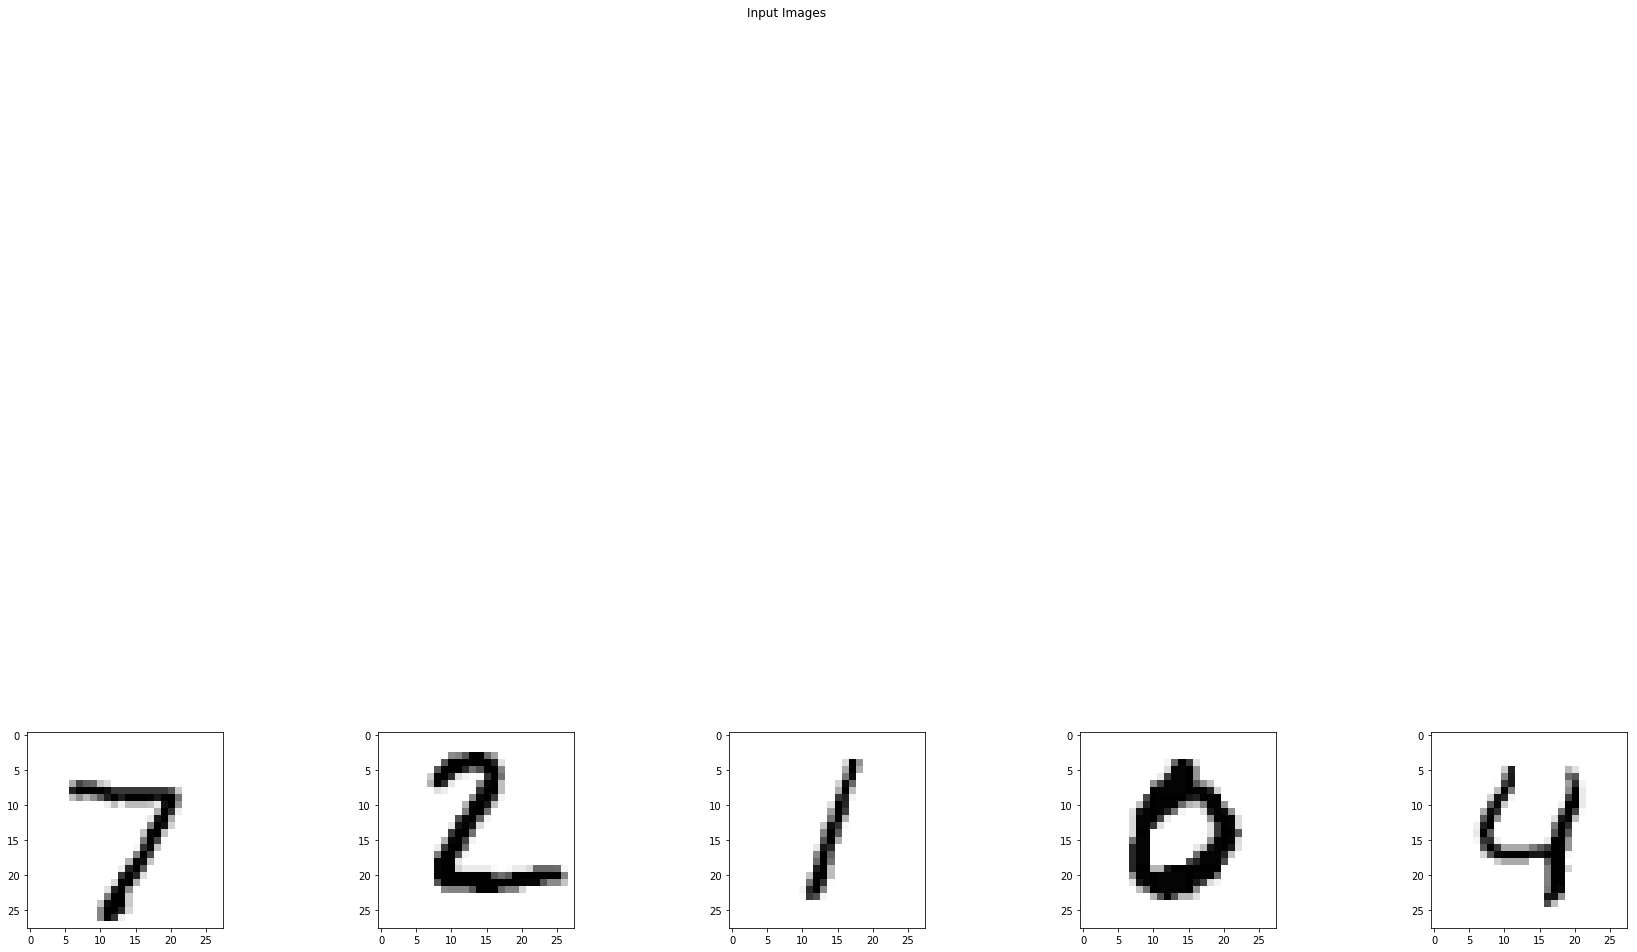

In [81]:
# für die Visualisierung der Gewichte und Aktivierungen
model_visualization_digit_caps = Model(input_shape, digit_caps)
result = model_visualization_digit_caps.predict(x_test[0:5,:,:,:])

model_visualization_output = Model(input_shape, outputs)
result2 = model_visualization_output.predict(x_test[0:5,:,:,:])


fig, axs = plt.subplots(1,5)
fig.suptitle('Input Images')
fig.tight_layout()
fig.set_figheight(25)
fig.set_figwidth(25)

for i in range(0,5):
    axs[i].imshow(x_test[i:i+1,:,:,:].reshape(28,28), cmap='binary')

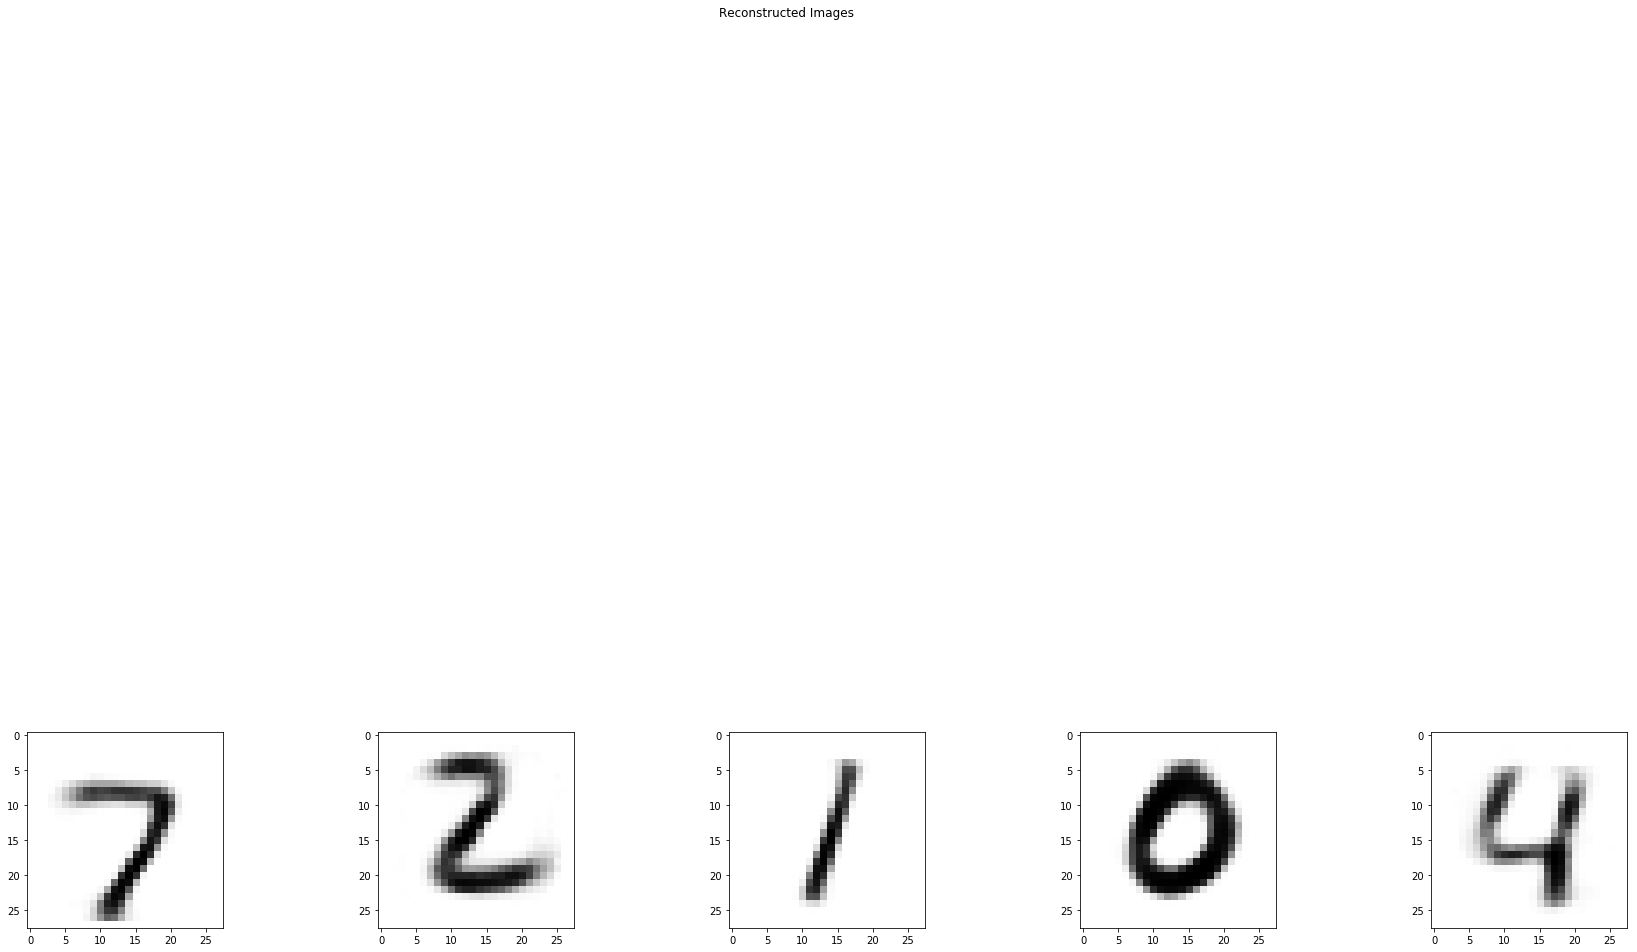

In [82]:
fig, axs = plt.subplots(1,5)
fig.suptitle('Reconstructed Images')
fig.tight_layout()
fig.set_figheight(25)
fig.set_figwidth(25)

for i in range(0,5):
    axs[i].imshow(image_predicted[i].reshape(28,28), cmap='binary')

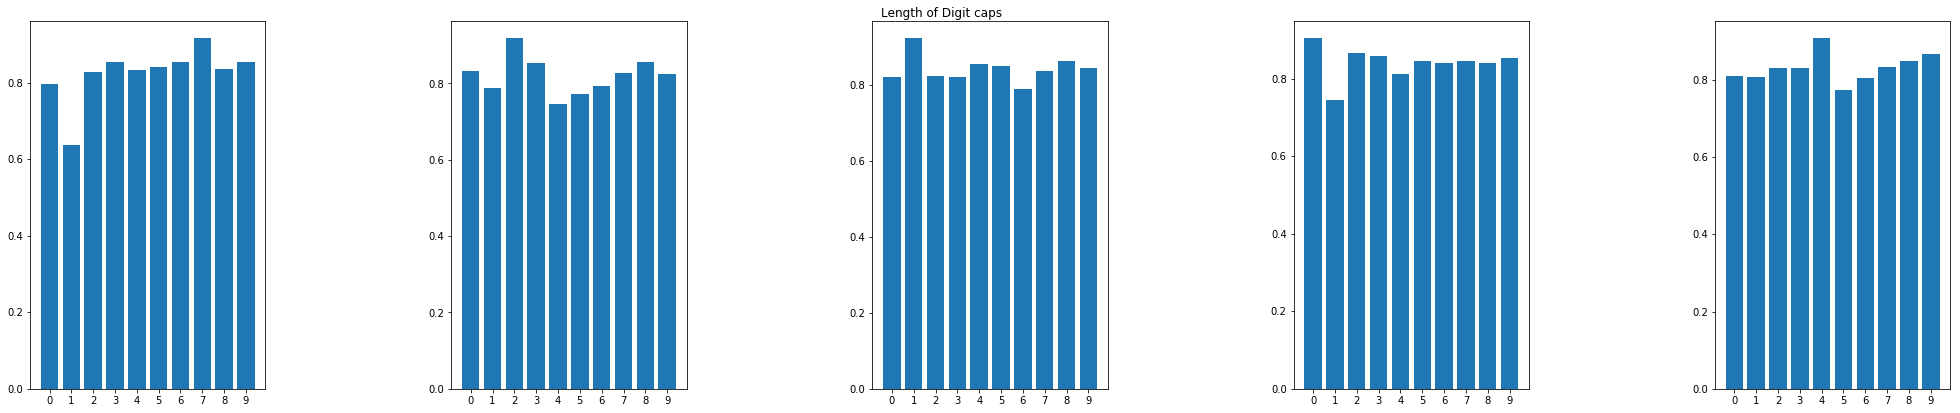

In [83]:
fig, axs = plt.subplots(1,5)
fig.suptitle('Length of Digit caps')
fig.tight_layout()
fig.set_figheight(6)
fig.set_figwidth(30)

for i in range(0,5):
    axs[i].bar(np.arange(10),result2[i].reshape(10))
    axs[i].set_xticks(np.arange(10))